# Анализ вакансий DS и DA

**Описание проекта:** <br>

Исследование вакансий Data Scientist и Data Analyst.

**Цель исследования:** <br>

Показать чем различаются предлагаемые вакансии Data Scientist и Data Analyst.

**План работы:**

1) Загрузим данные и подготовим их к анализу.
2) Проведем исследовательский анализ данных.
3) Определение доли грейдов Junior, Junior+, Middle, Senior среди вакансий Аналитик данных и Специалист по Data Science.
4) Определение наиболее желаемых кандидатов на вакансии Аналитик данных и Специалист по Data Science по следующим параметрам: самые важные hard-skils, самые важные soft-skils. Ответ отдельно дайте для грейдов Junior, Junior+, Middle, Senior.
5) Определение типичного места работы для Аналитика данных и специалист по Data Science по следующим параметрам: ТОП-работодателей, зарплата, тип занятости, график работы. Ответ отдельно дайте для грейдов Junior, Junior+, Middle, Senior.
6) Расчет помесячной динамики количества вакансий для Аналитика данных и специалиста по Data Science. Ответ отдельно дайте для грейдов Junior, Junior+, Middle, Senior.
7) Формулирование выводов и рекомендаций.
8) Создание презентации.

**Описание данных:**

В нашем распоряжении два датасета о активных вакансиях представленных на сайте HH.ru 13.05.2024. Данные получены из API HH.ru.

`da.csv` - вакансии аналитиков данных<br>
`ds.csv` - вакансии датасаентистов

Столбцы в двух таблицах идентичны:

- `id` -  уникальный номер вакансии
- `name` - название вакансии
- `published_at` - дата публикации вакансии(Для каждой вакансии мы сохраням только первую дату публикации)
- `alternate_url` - ссылка на вакансию
- `type` - тип вакансии
- `employer` - работодатель
- `department` - подразделение работодателя
- `area` - регион вакансии
- `experience` - требуемый опыт работы
- `key_skills` - требуемые скиллы
- `schedule` - график работы
- `employment` - тип занятости
- `description` - подробное описание вакансии
- `salary_from` - зарплата от
- `salary_to` -  зарплата до
- `currency_salary` - валюта зарплаты

---

## Загрузка данныx и подготовка их к анализу

---

In [1]:
import warnings
import pandas as pd
from pymystem3 import Mystem
import numpy as np
from tqdm.notebook import tqdm
import re

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from matplotlib import rcParams
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from collections import Counter
import requests

warnings.filterwarnings("ignore", "use_inf_as_na")
sns.set_theme(style="whitegrid", palette="pastel")

---

### Общая информация о данных

---

Посмотрим как выглядят данные

In [2]:
# приведем published_at сразу в формат даты
da = pd.read_csv('data/da.csv', parse_dates=['published_at'])
da.sample(5)

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,salary_from,salary_to
711,97237440,Аналитик данных (административно-хозяйственный...,2024-04-17 15:40:44,https://hh.ru/vacancy/97237440,Открытая,"МАГНИТ, Розничная сеть",NaN,Нижний Новгород,От 1 года до 3 лет,"['Excel', 'SQL']",Удаленная работа,Полная занятость,Чем предстоит заниматься: Многосторонним и де...,NaN,NaN
750,97341906,Sustainability Data Analyst,2024-04-18 15:30:10,https://hh.ru/vacancy/97341906,Открытая,СЕРВИСНЫЙ ЦЕНТР ERG,NaN,Астана,От 3 до 6 лет,[],Полный день,Полная занятость,"Principal accountabilities: Collect, consolid...",NaN,NaN
279,95071686,Data Analyst,2024-03-19 16:08:00,https://hh.ru/vacancy/95071686,Открытая,СБЕР,Сбер. IT,Москва,Junior+ (1-3 years),"['Коммуникация', 'Qlik Sense', 'SQL']",Полный день,Полная занятость,мы ищем опытного аналитика данных в команду ра...,NaN,NaN
889,97789602,Аналитик данных,2024-04-24 09:48:06,https://hh.ru/vacancy/97789602,Открытая,HRLink,NaN,Санкт-Петербург,От 1 года до 3 лет,"['Анализ данных', 'Аналитическое мышление', 'P...",Удаленная работа,Полная занятость,Привет! Это HRlink — первая в России платформа...,NaN,NaN
272,95014191,BI data-аналитик,2024-04-15 11:05:05,https://hh.ru/vacancy/95014191,Открытая,Siberian Wellness,NaN,Новосибирск,От 1 года до 3 лет,"['Oracle Pl/SQL', 'ORACLE', 'Tableau']",Полный день,Полная занятость,"Siberian Wellness – больше, чем просто произво...",NaN,NaN


In [3]:
# приведем published_at сразу в формат даты
ds = pd.read_csv('data/ds.csv', parse_dates=['published_at'])
ds.sample(5)

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,salary_from,salary_to
295,95125384,Data Scientist (Computer Vision),2024-03-20 13:17:49,https://hh.ru/vacancy/95125384,Открытая,Неофлекс,NaN,Нижний Новгород,Middle (3-6 years),"['Scikit Learn', 'Python', 'OpenCV', 'Docker',...",Полный день,Полная занятость,наш отдел data science в поиске специалиста по...,NaN,NaN
758,98526373,Data Scientist,2024-05-07 10:13:21,https://hh.ru/vacancy/98526373,Открытая,Ингосстрах,NaN,Москва,От 1 года до 3 лет,"['Python', 'Linux', 'Spark', 'Английский язык'...",Удаленная работа,Полная занятость,Команда Отдела моделирования группы Инго ищет ...,NaN,NaN
201,94593967,Data Scientist/Python-разработчик,2024-05-06 09:57:16,https://hh.ru/vacancy/94593967,Открытая,ИК СИБИНТЕК,"ИК ""Сибинтек""",Москва,От 3 до 6 лет,"['NLP', 'Python', 'Data Science']",Полный день,Полная занятость,Единая цифровая платформа Сибинтек – ведущий п...,NaN,NaN
208,94626215,Аналитик (Data science),2024-03-12 17:29:03,https://hh.ru/vacancy/94626215,Открытая,Ингосстрах Банк,NaN,Москва,Junior+ (1-3 years),"['RBP', 'Pandas', 'NCL', 'Python', 'NPV', 'SQL']",Полный день,Полная занятость,банк для меня: уверенность – мы соблюдаем тк ...,NaN,NaN
264,94975574,Senior Data scientist,2024-05-05 15:36:02,https://hh.ru/vacancy/94975574,Открытая,AMarkets,NaN,Москва,От 3 до 6 лет,[],Полный день,Полная занятость,Fintech компания AMarkets с 2007 года предоста...,NaN,NaN


---

Добавим флаговую переменную(которая будет принимать два значения "da" или "ds") и объеденим данные, чтобы на этапе обработке было удобнее с ними работать

In [4]:
# Создаем переменные
da['name_type'] = 'da'
ds['name_type'] = 'ds'

# объеденяем таблицы
vacancies = pd.concat((da, ds))
start_data_size = vacancies.shape[0]

---

Посмотрим общую информацию о датасете

In [5]:
vacancies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2025 entries, 0 to 804
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             2025 non-null   int64         
 1   name           2025 non-null   object        
 2   published_at   2025 non-null   datetime64[ns]
 3   alternate_url  2025 non-null   object        
 4   type           2025 non-null   object        
 5   employer       2025 non-null   object        
 6   department     621 non-null    object        
 7   area           2025 non-null   object        
 8   experience     2025 non-null   object        
 9   key_skills     2025 non-null   object        
 10  schedule       2025 non-null   object        
 11  employment     2025 non-null   object        
 12  description    2025 non-null   object        
 13  salary_from    291 non-null    float64       
 14  salary_to      199 non-null    float64       
 15  name_type      2025 non-nul

Видно что работодатели зачастую не вносят информацию о зарплате. 

---

### Поиск дубликатов

---

Мы хотим сравнить две группы аналитиков и датасаентистов. В наших данных есть смежные вакансии - Аналитик данных/Data Scientist, так как непонятно к какой группе их отнести, давайте посмотрим сколько этих данных в нашем датасете и удалим их.

In [6]:
grid = vacancies.name.str.lower().str.contains(r'data scien') \
    & (vacancies.name.str.lower().str.contains(r'analyst') \
    | vacancies.name.str.lower().str.contains(r'аналитик'))
vacancies[grid].sort_values(by='id')

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,salary_from,salary_to,name_type
56,91765959,Дата аналитик (Data Scientist),2024-04-04 10:10:44,https://hh.ru/vacancy/91765959,Открытая,Центр финансовых технологий,NaN,Санкт-Петербург,Junior+ (1-3 years),['Pandas'],Полный день,Полная занятость,приглашаем в ml команду специалистов в области...,NaN,NaN,da
63,91765959,Дата аналитик (Data Scientist),2024-04-04 10:10:44,https://hh.ru/vacancy/91765959,Открытая,Центр финансовых технологий,NaN,Санкт-Петербург,Junior+ (1-3 years),['Pandas'],Полный день,Полная занятость,приглашаем в ml команду специалистов в области...,NaN,NaN,ds
64,91765960,Дата аналитик (Data Scientist),2024-03-28 06:25:29,https://hh.ru/vacancy/91765960,Открытая,Центр финансовых технологий,NaN,Новосибирск,Junior+ (1-3 years),['Pandas'],Полный день,Полная занятость,приглашаем в ml команду специалистов в области...,NaN,NaN,ds
57,91765960,Дата аналитик (Data Scientist),2024-03-28 06:25:29,https://hh.ru/vacancy/91765960,Открытая,Центр финансовых технологий,NaN,Новосибирск,Junior+ (1-3 years),['Pandas'],Полный день,Полная занятость,приглашаем в ml команду специалистов в области...,NaN,NaN,da
70,92068025,"Аналитик данных (data scientist, data engineer)",2024-03-12 12:42:01,https://hh.ru/vacancy/92068025,Открытая,Федеральное государственное автономное учрежде...,NaN,Москва,Middle (3-6 years),"['Документация', 'Создание моделей', 'Оформлен...",Полный день,Полная занятость,в настоящее время фгау «нии «цэпп» расширяет к...,100000.0,NaN,ds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1162,98551181,Аналитик данных / Data Scientist (middle+),2024-05-07 14:36:58,https://hh.ru/vacancy/98551181,Открытая,"СИБУР, Группа компаний",Сибур,Москва,От 3 до 6 лет,"['Python', 'SQL', 'Математическая статистика']",Полный день,Полная занятость,СИБУР Диджитал - это цифровой кластер в состав...,NaN,NaN,da
774,98573757,Аналитик данных/Data Scientist,2024-05-07 20:09:28,https://hh.ru/vacancy/98573757,Открытая,Консорциум Кодекс,NaN,Санкт-Петербург,От 1 года до 3 лет,"['Machine Learning', 'Data Science', 'SQL', 'P...",Полный день,Полная занятость,"Основные задачи: Разработка, тестирование и в...",NaN,NaN,ds
1173,98573757,Аналитик данных/Data Scientist,2024-05-07 20:09:28,https://hh.ru/vacancy/98573757,Открытая,Консорциум Кодекс,NaN,Санкт-Петербург,От 1 года до 3 лет,"['Machine Learning', 'Data Science', 'SQL', 'P...",Полный день,Полная занятость,"Основные задачи: Разработка, тестирование и в...",NaN,NaN,da
1183,98592181,Аналитик данных/Junior DATA SCIENTIST,2024-05-08 09:12:01,https://hh.ru/vacancy/98592181,Открытая,БиАйЭй-Технолоджиз,NaN,Москва,От 1 года до 3 лет,[],Полный день,Полная занятость,Активно формируем новую команду для нашего кру...,NaN,NaN,da


Мы видим что каждая такая вакансия попала в обе выборке. У нас 115 таких наблюдения, давайте их удалим. 

In [7]:
vacancies = vacancies[~grid].sort_values(by='id')

In [8]:
print(f'Удалили {1 - vacancies.shape[0] / start_data_size:.2%} данных')

Удалили 5.68% данных


---

Создадим новую переменную `published_date`

In [9]:
vacancies['published_date'] = vacancies.published_at.dt.date

---

Посмотрим наличие дубликатов

In [10]:
n_dupl = vacancies.duplicated(
    subset='id'
).sum()
print(f'Количество дубликатов - {n_dupl}')

Количество дубликатов - 1


Посмотрим на дубликаты

In [11]:
vacancies[
    vacancies.duplicated(
        subset='id',
        keep=False
    )].sort_values(by=['name', 'employer', 'published_date'])

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,salary_from,salary_to,name_type,published_date
434,96061431,Data Scientist,2024-04-27 10:07:00,https://hh.ru/vacancy/96061431,Открытая,СБЕР,Сбер для экспертов,Москва,Middle (3-6 years),[],Полный день,Полная занятость,корпоративно-инвестиционный блок отвечает за р...,NaN,NaN,ds,2024-04-27
420,96061431,Аналитик данных (Голос клиента),2024-04-27 10:07:00,https://hh.ru/vacancy/96061431,Открытая,СБЕР,Сбер для экспертов,Москва,От 3 до 6 лет,[],Полный день,Полная занятость,Корпоративно-инвестиционный блок отвечает за р...,NaN,NaN,da,2024-04-27


Это одна и та же вакансия, судя по всему она сначала называлась Аналитик данных, а потом ее переименовали в Data Scientist, cтоит удалить эти наблюдения потому что не понятно к какой когорте их отнести.

In [12]:
vacancies.drop_duplicates(subset='id', keep=False, inplace=True)

In [13]:
print(f'Удалили {1 - vacancies.shape[0] / start_data_size:.2%} данных')

Удалили 5.78% данных


Проверим есть ли у нас одинаковые вакансии, но с разным id

In [14]:
vacancies[
    vacancies.duplicated(
        subset=['name', 'published_date', 'employer', 'department', 'area', 'description'],
        keep=False
    )].sort_values(by=['name', 'employer', 'published_date'])

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,salary_from,salary_to,name_type,published_date
945,97929624,Аналитик данных,2024-04-25 17:24:21,https://hh.ru/vacancy/97929624,Открытая,ГКУ Центр занятости населения города Москвы,NaN,Москва,От 1 года до 3 лет,[],Полный день,Полная занятость,Один из ключевых партнёров Центра занятости на...,150000.0,NaN,da,2024-04-25
946,97929739,Аналитик данных,2024-04-25 17:27:28,https://hh.ru/vacancy/97929739,Открытая,ГКУ Центр занятости населения города Москвы,NaN,Москва,От 1 года до 3 лет,[],Полный день,Полная занятость,Один из ключевых партнёров Центра занятости на...,NaN,NaN,da,2024-04-25


Удалим дубликат

In [15]:
vacancies.drop_duplicates(
    subset=['name', 'published_date', 'employer', 'department', 'area', 'description'],
    keep=False, inplace=True
)

In [16]:
print(f'Удалили {1 - vacancies.shape[0] / start_data_size:.2%} данных')

Удалили 5.88% данных


---

### Поиск аномальных значений

---

Посмотрим какие названия вакансий у нас в датасете

In [17]:
vacancies.name.value_counts()[:10]

name
Аналитик данных            198
Data Scientist             116
Data Analyst                83
Senior Data Scientist       24
Data scientist              20
Junior Data Scientist       19
Ведущий аналитик данных     17
Middle Data Scientist       15
Senior Data Analyst         15
Junior Data Analyst         12
Name: count, dtype: int64

In [18]:
vacancies.name.value_counts()[-10:]

name
Junior Data Scientist в SberData                                   1
Middle Data Scientist в Департамент "Занять и сберегать"           1
Data Analyst в Департамент данных и рекомендательных систем В2С    1
Middle/Senior Data Scientist в Блок B2C                            1
Data Scientist (LLM/ NlP) в Блок B2C                               1
Data analyst (Middle)                                              1
Системный аналитик данных                                          1
Team Lead Data Scientist в команду SberCampaigning                 1
Cпециалист по работе с данными (Data Scientist)                    1
Заместитель начальника отдела исследований и аналитики данных      1
Name: count, dtype: int64

Все просмотреть нет возможности, но тут вроде порядок.

---

Посмотрим минимальные и максимальные даты

In [19]:
print(f'Минимальная дата - {vacancies.published_at.min().strftime("%Y-%m-%d %X")}')
print(f'Максимальная дата - {vacancies.published_at.max().strftime("%Y-%m-%d %X")}')

Минимальная дата - 2024-02-29 15:01:35
Максимальная дата - 2024-05-12 09:29:39


У нас данные с конца февраля до середины мая.

---

Посмотрим какие регионы присутствуют в нашем датасете

In [20]:
vacancies[vacancies.name_type == 'da'].area.value_counts()[:25]

area
Москва             780
Санкт-Петербург     96
Ташкент             26
Алматы              25
Екатеринбург        25
Минск               19
Нижний Новгород     17
Новосибирск         15
Владивосток         13
Казань              12
Краснодар           12
Астана              10
Сербия              10
Ростов-на-Дону       7
Тбилиси              7
Бишкек               5
Красноярск           4
Владимир             4
Самара               4
Воронеж              4
Челябинск            4
Саратов              4
Тюмень               4
Шымкент              3
Калининград          3
Name: count, dtype: int64

У нас представлены не только российские города, но и города из ближнего зарубежья.

---

Посмотрим значения в переменной `experience`

In [21]:
vacancies.experience.value_counts()

experience
От 1 года до 3 лет       791
От 3 до 6 лет            540
Junior+ (1-3 years)      207
Middle (3-6 years)       195
Нет опыта                117
Более 6 лет               26
Junior (no experince)     18
Senior (6+ years)         12
Name: count, dtype: int64

Привидем все значения к общему виду

In [22]:
def calc_experience(value: str) -> str:
    """
    Определяет уровень опыта на основе переданной строки.

    Функция анализирует строку, содержащую информацию об опыте работы, 
    и возвращает квалификационный уровень в соответствии с найденными данными.
    Если опыт работы не указан, возвращает уровень 'Junior (no experience)'.

    Parameters:
    value (str): Строка, содержащая информацию об опыте работы.

    Returns:
    str: Квалификационный уровень на основе опыта работы.
    """
    
    # Если первый символ строки меньше 'А', возвращаем исходное значение
    if value[0] < 'А':
        return value
    
    # Используем регулярное выражение для поиска цифр в строке
    experience = re.findall(r'd', value)
    
    # Если цифры не найдены, считаем, что опыт работы отсутствует
    if not experience:
        return 'Junior (no experience)'
    
    # Возвращаем соответствующий уровень опыта на основе найденной первой цифры
    if experience[0] == '6':
        return 'Senior (6+ years)'
    if experience[0] == '1':
        return 'Junior+ (1-3 years)'
    if experience[0] == '3':
        return 'Middle (3-6 years)'


In [23]:
vacancies.experience = vacancies.experience.map(calc_experience)

---

Посмотрим какие значения принимает переменная `schedule`(график работы)

In [24]:
vacancies.schedule.value_counts()

schedule
Полный день         1500
Удаленная работа     331
Гибкий график         64
Сменный график        10
Вахтовый метод         1
Name: count, dtype: int64

Интересно посмотреть на вакансию с вахтовым методом:)

In [25]:
vacancies[vacancies.schedule == 'Вахтовый метод']

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,salary_from,salary_to,name_type,published_date
695,97189840,Аналитик по работе с базами данных (MS Excel),2024-04-17 09:37:54,https://hh.ru/vacancy/97189840,Открытая,РХИ,NaN,Свободный,Junior (no experience),"['MS Excel', 'Управленческая отчетность', 'Раб...",Вахтовый метод,Полная занятость,"Уважаемые соискатели, Мы в поиске сотрудника н...",NaN,NaN,da,2024-04-17


---

Посмотрим какие значения принимает переменная `employment`

In [26]:
vacancies.employment.value_counts()

employment
Полная занятость       1856
Стажировка               27
Проектная работа         16
Частичная занятость       7
Name: count, dtype: int64

Тут полный порядок

---

In [27]:
vacancies.reset_index(drop=True, inplace=True)

---

### Создание признаков

---

Проведем лемматизацию описания и результат сохраним в новый столбец `description_lemmatized`

In [28]:
def lemmatize_corpus(description: pd.Series) -> pd.Series:
    """
    Производит лемматизацию серии текстовых данных.

    Эта функция принимает на вход серию текстовых данных (pd.Series), 
    объединяет их в один текст, разделяя маркером ' br ', 
    затем применяет к нему лемматизацию и возвращает новую серию, 
    где каждый элемент представляет собой лемматизированный текст.

    Parameters:
    description (pd.Series): Серия текстовых данных для лемматизации.

    Returns:
    pd.Series: Серия лемматизированных текстовых данных.
    """
    
    # Объединение всех текстов в одну строку с маркером ' br ' для разделения текстов
    texts = ' br '.join(description.to_list())
    
    # Инициализация лемматизатора
    stem = Mystem()
    
    print('Запуск лемматизации')
    # Применение лемматизации к объединенному тексту
    text_lemm = stem.lemmatize(texts)
    
    # Инициализация списка для хранения лемматизированных текстов
    data = []
    # Временный список для хранения слов текущего текста
    temp = []
    
    # Проходим по всем словам в лемматизированном тексте
    for word in tqdm(text_lemm):
        # Если встречаем маркер 'br', значит это конец текущего текста
        if word == 'br':
            # Добавляем лемматизированный текст в список data
            data.append(' '.join([word for word in temp if word.isalpha()]))
            # Очищаем временный список для следующего текста
            temp = []
        else:
            # Добавляем слово в временный список
            temp.append(word)
    # Добавляем последний текст в список data
    data.append(' '.join([word for word in temp if word.isalpha()]))
    
    # Преобразуем список лемматизированных текстов в pd.Series
    data = pd.Series(data, name='description_lemmatized')
    
    # Проверка на соответствие размеров входной и выходной серий
    assert description.shape[0] == data.shape[0]
    
    return data


In [29]:
vacancies['description_lemmatized'] = lemmatize_corpus(vacancies.description)

Запуск лемматизации


  0%|          | 0/992796 [00:00<?, ?it/s]

---

Создадим переменную `skills` - значение переменной будет строка содержащая скиллы вакансии через пробел.

Сначала найдем самые популярные скиллы из столбца `key_skills`, которые встречаются более 20 раз

In [30]:
# Создаем новую колонку 'skills_from_key_skills' в DataFrame 'vacancies'
# В этой колонке для каждой вакансии будет храниться уникальный набор навыков,
# приведенный к нижнему регистру
vacancies['skills_from_key_skills'] = (
    vacancies['key_skills'].map(
        lambda x: ', '.join(set([skill[1:-1] for skill in x[1:-1].lower().split(', ')])))
)

# Преобразуем колонку 'skills_from_key_skills' в список для дальнейшей обработки
skills_data = vacancies['skills_from_key_skills'].to_list()

# Инициализируем словарь для подсчета частоты встречаемости каждого навыка
counter = {}

# Проходим по всем навыкам в списке 'skills_data'
for sequence in skills_data:
    # Разделяем строку с навыками на уникальные элементы и преобразуем в множество
    skills = set(sequence.split(', '))
    # Подсчитываем количество вхождений каждого навыка
    for skill in skills:
        counter[skill] = counter.get(skill, 0) + 1

# Фильтруем словарь 'counter', оставляя только те навыки, которые встречаются более 20 раз
counter = {k: v for k, v in counter.items() if v > 20}

# Сортируем словарь 'counter' по убыванию частоты встречаемости навыков
counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

Посмотрим на посмотрим на словарь скилов который у нас получился

In [31]:
counter

{'python': 716,
 'sql': 695,
 '': 660,
 'анализ данных': 309,
 'pandas': 225,
 'аналитическое мышление': 177,
 'power bi': 159,
 'data analysis': 145,
 'работа с базами данных': 143,
 'ms excel': 132,
 'machine learning': 131,
 'работа с большим объемом информации': 126,
 'аналитика': 113,
 'математическая статистика': 112,
 'ms sql': 106,
 'big data': 105,
 'data science': 100,
 'ml': 98,
 'базы данных': 97,
 'postgresql': 85,
 'pytorch': 79,
 'статистический анализ': 73,
 'git': 69,
 'spark': 67,
 'английский язык': 66,
 'hadoop': 65,
 'nlp': 64,
 'сбор и анализ информации': 60,
 'аналитические исследования': 59,
 'документация': 59,
 'tableau': 57,
 'ms powerpoint': 53,
 'etl': 53,
 'numpy': 52,
 'clickhouse': 51,
 'машинное обучение': 49,
 'коммуникация': 48,
 'a/b тесты': 46,
 'математический анализ': 45,
 'dwh': 45,
 'математическое моделирование': 42,
 'airflow': 42,
 'анализ бизнес показателей': 41,
 'прогнозирование': 40,
 'linux': 40,
 'бизнес-анализ': 39,
 'tensorflow': 37,


Немного подредактируем данный словарь. Уберем пустую строку. Уберем скиллы которые несут только общую информацию о профессии(например: machine learning, data analysis и т.д.) Уберем приставку ms у продуктов microsoft кроме ms sql.

In [32]:
del counter['']
del counter['анализ данных']
del counter['data analysis']
del counter['machine learning']
del counter['аналитика']
del counter['data science']
del counter['ml']
del counter['аналитические исследования']
del counter['машинное обучение']
del counter['работа с большим объемом информации']

del counter['ms excel']
del counter['ms powerpoint']
del counter['ms power bi']

# сохраняем скиллы во множестве и добавляем нужные элементы
SKILLS = set(counter.keys()).union({'excel', 'powerpoint', 'power bi'})

In [33]:
def calc_skills_from_description(value: str) -> str:
    """
    Извлекает навыки из описания, используя заданный список навыков SKILLS.

    Функция проходит по словам в строке 'value', объединяет их в группы от одного до четырех слов,
    и если сочетание слов является навыком из списка SKILLS, добавляет его в результат.
    Результат возвращает в виде строки, где навыки разделены запятой.

    Parameters:
    value (str): Строка с описанием, из которой необходимо извлечь навыки.

    Returns:
    str: Строка с уникальными навыками, извлеченными из описания.
    """
    res = []  # Инициализация списка для хранения найденных навыков
    value = value.lower().split()  # Приведение строки к нижнему регистру и разделение на слова
    start = 0  # Начальный индекс для среза слов
    stop = 4  # Конечный индекс для среза слов

    # Пока конечный индекс не превысит количество слов в строке
    while stop <= len(value):
        skill = ' '.join(value[start:stop])  # Объединение слов в потенциальный навык
        if skill in SKILLS:  # Проверка, является ли сочетание слов навыком
            res.append(skill)  # Добавление навыка в результат
            start = stop  # Сдвиг начального индекса
            stop = start + 4  # Сдвиг конечного индекса
        else:
            # Уменьшение конечного индекса для проверки следующего сочетания слов
            if start < stop - 1:
                stop -= 1
            else:
                # Сдвиг начального индекса, если не найдено сочетаний
                start = stop
                stop = start + 4
    return ', '.join(set(res))  # Возврат строки с уникальными навыками

def calc_skills(row: dict) -> str:
    """
    Вычисляет итоговый набор навыков из двух полей строки DataFrame: 'skills_from_description' и 'skills_from_key_skills'.

    Если одно из полей пустое, возвращает значение другого поля. Если оба поля содержат значения,
    объединяет их в один уникальный набор навыков.

    Returns:
    str: Строка с уникальными навыками, полученными из обоих полей.
    """
    # Проверка и возврат навыков из описания, если поле с навыками из описания пусто
    if row['skills_from_description'] == '':
        return row['skills_from_key_skills']
    # Проверка и возврат навыков из ключевых слов, если поле с навыками из ключевых навыков пусто
    if row['skills_from_key_skills'] == '':
        return row['skills_from_description']
    # Объединение и возврат уникальных навыков из обоих полей
    return ', '.join(set(row['skills_from_description'].split(', ') + row['skills_from_key_skills'].split(', ')))


Получим скиллы из описания и создадим столбец, где объединим все полученные скиллы

In [34]:
vacancies['skills_from_description'] = vacancies['description_lemmatized'].map(calc_skills_from_description)
vacancies['skills'] = vacancies.apply(calc_skills, axis=1)

---

Создадим переменную `salary_cat`, которая будет содержать категорию заработной платы.

In [35]:
def calc_salary_bin(row: pd.Series) -> str:
    """
    Категоризирует зарплатные предложения вакансий по их размеру.

    Функция принимает строку DataFrame, содержащую информацию о зарплате (salary_to и salary_from),
    и возвращает категорию зарплаты в зависимости от указанных значений.

    Parameters:
    row (pd.Series): Строка DataFrame, содержащая информацию о зарплатных предложениях.

    Returns:
    str: Категория зарплаты.
    """
    
    # Проверяем отсутствие данных о зарплате
    if row.isna()['salary_to'] and row.isna()['salary_from']:
        return 'ЗП не указана'
    
    # Категоризация верхнего порога зарплаты, если он указан
    if not row.isna()['salary_to']:
        if row['salary_to'] > 3e5:
            return 'Больше 300 тысяч'
        if row['salary_to'] > 2e5:
            return 'От 200 тысяч до 300 тысяч'
        if row['salary_to'] > 1e5:
            return 'От 100 тысяч до 200 тысяч'
        else:
            return 'Меньше 100 тысяч'
    
    # Категоризация нижнего порога зарплаты, если верхний порог не указан
    if not row.isna()['salary_from']:
        if row['salary_from'] >= 3e5:
            return 'Больше 300 тысяч'
        if row['salary_from'] >= 2e5:
            return 'От 200 тысяч до 300 тысяч'
        if row['salary_from'] >= 1e5:
            return 'От 100 тысяч до 200 тысяч'
        else:
            return 'Меньше 100 тысяч'

In [36]:
vacancies['salary_bin'] = vacancies.apply(calc_salary_bin, axis=1)

---

Создадим переменную `salary_num`, которая будет содержать зарплату в числовом формате или nan если зарплата не указана.

In [37]:
def calc_salary_num(row: pd.Series) -> float:
    """
    Вычисляет среднее значение зарплаты на основе верхнего и нижнего порогов.

    Функция принимает строку DataFrame, содержащую информацию о зарплатных предложениях
    (salary_to и salary_from), и возвращает среднее значение, если указаны оба порога,
    или одно из значений, если указан только один порог.

    Parameters:
    row (pd.Series): Строка DataFrame, содержащая информацию о зарплатных предложениях.

    Returns:
    float: Среднее значение зарплаты или один из указанных порогов.
    """
    
    # Проверяем, указаны ли оба порога зарплаты, и если да, возвращаем их среднее
    if not row.isna()['salary_to'] and not row.isna()['salary_from']:
        return (row['salary_to'] + row['salary_from']) / 2
    
    # Возвращаем верхний порог зарплаты, если он указан
    if not row.isna()['salary_to']:
        return row['salary_to']
    
    # Возвращаем нижний порог зарплаты, если он указан
    if not row.isna()['salary_from']:
        return row['salary_from']

In [38]:
vacancies['salary_num'] = vacancies.apply(calc_salary_num, axis=1)

---

Посмотрим распределение заработной платы

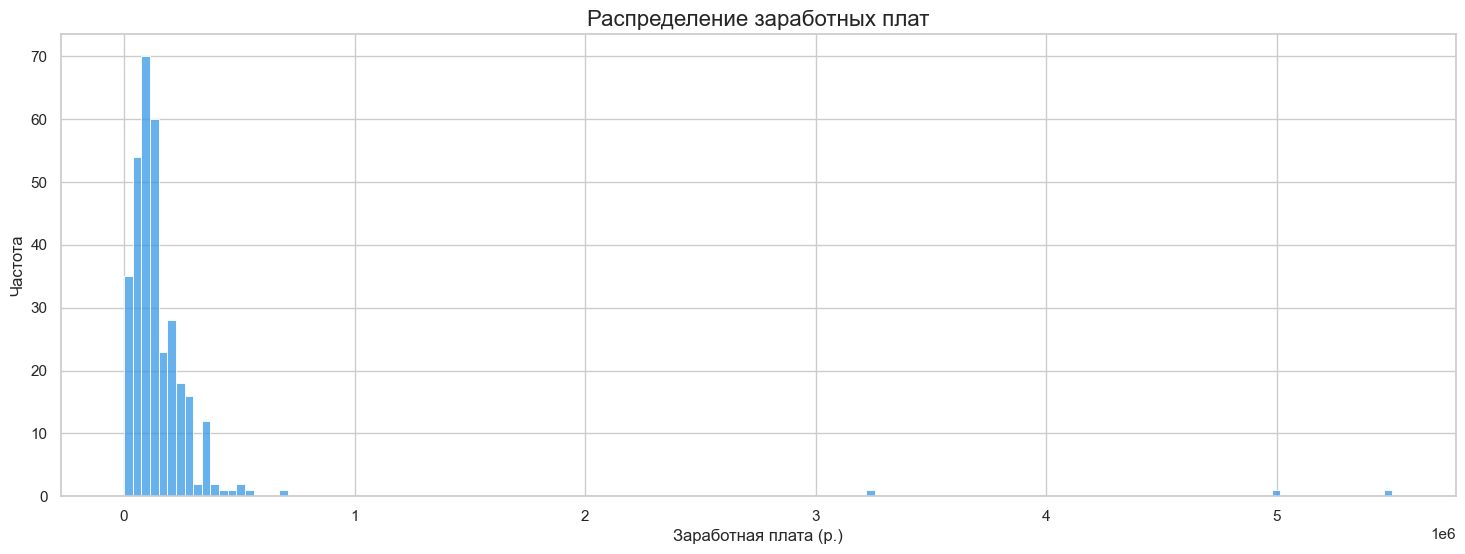

In [39]:
# Создаем гистограмму распределения зарплат
plt.figure(figsize=(18, 6))  # Устанавливаем размер фигуры
ax = sns.histplot(data=vacancies[~vacancies.isna()], x='salary_num', color='#3498E8', edgecolor='#FFFFFF')

# Устанавливаем заголовок и размер шрифта
ax.set_title('Распределение заработных плат', fontsize=16)
ax.set_ylabel('Частота')
ax.set_xlabel('Заработная плата (р.)')

# Отображаем гистограмму
plt.show()

Посмотрим на заработные платы более 1 миллионов и меннее 20 тысяч.

In [40]:
grid = vacancies.salary_num > 1e6
vacancies[grid]

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,...,salary_from,salary_to,name_type,published_date,description_lemmatized,skills_from_key_skills,skills_from_description,skills,salary_bin,salary_num
261,93717522,Помощник аналитика - оператор базы данных,2024-05-03 08:27:25,https://hh.ru/vacancy/93717522,Открытая,SERENE PHARMA,NaN,Ташкент,Junior (no experience),"['Работа с базами данных', 'MS PowerPoint', 'Г...",...,3000000.0,3500000.0,da,2024-05-03,обязанность ведение база данные мед представит...,"грамотность, ms access, работа с базами данных...",,"грамотность, ms access, работа с базами данных...",Больше 300 тысяч,3250000.0
893,96502112,Аналитик базы данных,2024-04-09 10:37:10,https://hh.ru/vacancy/96502112,Открытая,AKFA BUILDING MATERIALS,NaN,Ташкент,Junior (no experience),[],...,5000000.0,NaN,da,2024-04-09,обязанность программирование модель и отчет Ql...,,"документация, excel, sql","документация, excel, sql",Больше 300 тысяч,5000000.0
1177,97207792,Аналитик данных,2024-04-17 11:44:34,https://hh.ru/vacancy/97207792,Открытая,Ashley Furniture HomeStore Uzbekistan,NaN,Ташкент,Junior (no experience),[],...,4000000.0,7000000.0,da,2024-04-17,позиция аналитик данные обязанность сбор и ана...,,английский язык,английский язык,Больше 300 тысяч,5500000.0


Это вакансии в узбекистане, скорее всего зарплата указана в местной валюте. Получим курс узбекского сума и переведем в рубли.

In [41]:
# получаем курс валют ЦБ
data = requests.get('https://www.cbr-xml-daily.ru/daily_json.js').json()

# вычисляем курс обмена
uzs = data['Valute']['UZS']
rates = uzs['Value'] / uzs['Nominal']

vacancies.loc[grid, 'salary_num'] = vacancies[grid].salary_num * rates

In [42]:
grid = vacancies.salary_num < 20_000
vacancies[grid]

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,...,salary_from,salary_to,name_type,published_date,description_lemmatized,skills_from_key_skills,skills_from_description,skills,salary_bin,salary_num
242,93553355,Аналитик данных,2024-04-25 10:56:52,https://hh.ru/vacancy/93553355,Открытая,"СОСЕДИ, Сеть магазинов",NaN,Минск,Junior (no experience),[],...,1600.0,1900.0,da,2024-04-25,обязанность получение данные из несколько исто...,,"документация, excel, python","документация, excel, python",Меньше 100 тысяч,1750.0
307,94100628,Data Analyst (middle/senior),2024-05-06 12:51:55,https://hh.ru/vacancy/94100628,Открытая,Fundraise Up,NaN,Москва,Junior (no experience),"['SQL', 'Английский язык', 'PostgreSQL', 'A/B ...",...,3700.0,5300.0,da,2024-05-06,искать дата аналитик с год опыт на удаленный р...,"a/b тесты, sql, английский язык, postgresql, d...","bi, python, clickhouse, tableau, numpy, pandas...","bi, python, clickhouse, tableau, numpy, pandas...",Меньше 100 тысяч,4500.0
308,94100637,"Data Analyst (middle/senior), Remote",2024-05-06 12:52:07,https://hh.ru/vacancy/94100637,Открытая,Fundraise Up,NaN,Тбилиси,Junior (no experience),"['SQL', 'Английский язык', 'PostgreSQL', 'A/B ...",...,3700.0,5300.0,da,2024-05-06,искать дата аналитик с год опыт на удаленный р...,"a/b тесты, sql, английский язык, postgresql, d...","bi, python, clickhouse, tableau, numpy, pandas...","bi, python, clickhouse, tableau, numpy, pandas...",Меньше 100 тысяч,4500.0
425,94738111,"Data scientist (стажер, junior, middle)",2024-04-13 09:30:26,https://hh.ru/vacancy/94738111,Открытая,ТТ мобайл (МегаФон Таджикистан),NaN,Таджикистан,Junior (no experience),"['Python', 'SQL', 'Numpy', 'Pandas', 'Scikit-l...",...,1000.0,NaN,ds,2024-04-13,первый оператор новый цифровой возможность и о...,"python, dataframe, numpy, pandas, scikit-learn...","python, numpy, pandas, hadoop, sql, tensorflow...","python, dataframe, numpy, pandas, scikit-learn...",Меньше 100 тысяч,1000.0
867,96431016,Data analyst (Vietnam),2024-05-06 08:51:21,https://hh.ru/vacancy/96431016,Открытая,Finstar Financial Group,NaN,Москва,Junior (no experience),"['Python', 'SQL', 'Управление проектами', 'Обу...",...,2000.0,NaN,da,2024-05-06,Finstar Financial Group крупный международный ...,"python, управление проектами, обучение и разви...","sql, etl, python, power bi","python, управление проектами, обучение и разви...",Меньше 100 тысяч,2000.0
895,96503377,Аналитик данных SQL (Middle),2024-04-20 08:43:49,https://hh.ru/vacancy/96503377,Открытая,SoftGamings,NaN,Сербия,Junior (no experience),"['Английский язык', 'Transact-SQL', 'Оптимизац...",...,1100.0,1700.0,da,2024-04-20,в связь с расширение команда международный IT ...,"ms sql, transact-sql, sql, базы данных, англий...","python, linux, numpy, pandas, airflow, sql, etl","python, linux, ms sql, numpy, pandas, airflow,...",Меньше 100 тысяч,1400.0
950,96627127,Data Scientist / ML Engineer (рекомендательная...,2024-04-10 14:57:17,https://hh.ru/vacancy/96627127,Открытая,AINAUTS LLC,NaN,Тбилиси,Junior (no experience),"['R', 'Python', 'Data Science', 'Machine Learn...",...,7000.0,NaN,ds,2024-04-10,привет мы приглашать опытный Data Scientist ML...,"статистический анализ, machine learning, pytho...","статистический анализ, python","статистический анализ, machine learning, r, py...",Меньше 100 тысяч,7000.0
1104,97037308,Специалист по аналитике первичных данных,2024-05-07 12:07:39,https://hh.ru/vacancy/97037308,Открытая,Евроторг,NaN,Минск,Junior (no experience),[],...,1390.0,1740.0,da,2024-05-07,обязанность аналитика первичный данные в корпо...,,,,Меньше 100 тысяч,1565.0
1111,97041429,Data Analyst / Аналитик Данных,2024-05-06 17:52:08,https://hh.ru/vacancy/97041429,Открытая,Wannabe,NaN,Москва,Junior (no experience),"['Data Analysis', 'Python', 'MS SQL', 'Black b...",...,3000.0,5000.0,da,2024-05-06,команда Wannabe Recruitment искать аналитика д...,"python, black box testing, ms sql, a/b тесты, ...","python, коммуникация, tableau","python, black

Скорее всего эта зарплата указана в долларах США получим курс и конвертируем зарплату.

In [43]:
# вычисляем курс
usd = data['Valute']['USD']
rates = usd['Value'] / usd['Nominal']

vacancies.loc[grid, 'salary_num'] = vacancies[grid].salary_num * rates

---

## Исследовательский анализ данных

---

### Посмотрим баланс аналитиков и датасаентистов в выборке

Общее количество вакансий - 1906


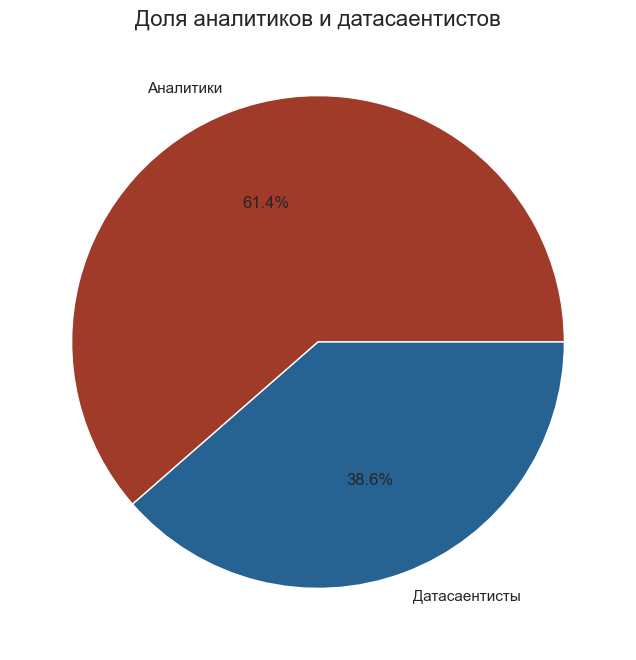

In [44]:
df = vacancies.name_type.value_counts().reset_index()
print(f'Общее количество вакансий - {vacancies.shape[0]}')
colors = ['#A03B2A', '#266292']

# Устанавливаем тему для графиков
sns.set(style="darkgrid")

# Создаем круговую диаграмму
plt.figure(figsize=(8, 8))  # Устанавливаем размер фигуры
plt.pie(df['count'], labels=['Аналитики', 'Датасаентисты'], colors=colors, autopct='%1.1f%%')

# Устанавливаем заголовок
plt.title('Доля аналитиков и датасаентистов', fontsize=16)

# Отображаем диаграмму
plt.show()

In [ ]:
df = vacancies.name_type.value_counts().reset_index()
print(f'Общее количество вакансий - {vacancies.shape[0]}')
colors = ['#A03B2A', '#266292']
fig = go.Figure(data=[go.Pie(labels=['Аналитики','Датасаентисты'],
                             values=df['count'])])
fig.update_layout(
        height=600, width=600, 
        title_text='Доля аналитиков и датасаентистов', 
        showlegend=True,
        template="plotly_dark",       
    )

fig.update_traces(textposition='outside', hoverinfo='label+value', 
                  textinfo='percent+label', textfont_size=12,
                  marker=dict(colors=colors, line=dict(color='#FFFFFF', width=2))
                 )

fig.show()

Общее количество вакансий - 1906


Вакансий аналитиков в полтора раза больше вакансий датасаентистов.

---

Посмотрим самые часто встречаемые названия вакансий для аналитиков и датасаентистов

In [56]:
def plot_discrete(name_type: str, 
                  top_n: int,
                  feature,
                  *,
                  rus_feature,
                  title_text, 
                  data=vacancies, 
                  color='#FF563A',
                  width=800,
                  height=800,
                  top=True
                 ) -> None:
    top_name = (
        data[data.name_type == name_type]
        [feature].value_counts()[:top_n]
        .reset_index()
        .sort_values(by='count')
        .rename(columns={'count': 'Количество вакансий', feature: rus_feature})
    )
    
    fig = px.bar(top_name, 'Количество вакансий', rus_feature, orientation='h')
    
    fig.update_traces(marker_color=color, marker_line_color='#FFFFFF',
                      marker_line_width=1.5, opacity=0.6)
    
    fig.update_layout(
        height=height, width=width, 
        title_text=title_text, 
        showlegend=False,
        template="plotly_dark",       
    )
    fig.show()

In [57]:
plot_discrete(
    'da', 7, 'name', 
    rus_feature='Название', 
    title_text='Топ-7 названий вакансий аналитиков',
    height=300
)

In [58]:
plot_discrete(
    'ds', 7, 'name', 
    rus_feature='Название', 
    title_text='Топ-7 названий вакансий датасаентистов',
    height=300,
    color='#3498E8'
)

Как видно из данных, наиболее востребованными на рынке труда являются позиции "Аналитик данных", "Data Analyst" и "Data Scientist". Это говорит о том, что соискателям, вероятно, не следует усложнять название своей специализации при поиске работы. Простота и понятность названия профессии могут оказаться ключевыми в успешном трудоустройстве.

---

Посмотрим на количество опубликованных вакансий в динамике

In [59]:
df = (
    vacancies.groupby(['name_type', 'published_date'])
    .name.count()
    .reset_index()
    .rename(columns={'name': 'Количество опубликованных вакансий',
                     'published_date': 'Дата'})
)
fig = px.line(df, x='Дата', 
              y='Количество опубликованных вакансий', 
              color='name_type'
             )
fig.data[0].line.color = '#FF563A'
fig.data[1].line.color = '#3498E8'
fig.update_layout(
        height=600, width=1200, 
        title_text=f"Количество опубликованных вакансий в динамике",
        showlegend=True,
        template="plotly_dark",
        
    )
fig.show()

Анализируя график мы можем увидеть, что объем вакансий, опубликованных в период с 29 февраля по 8 мая 2024 года, показывает значительное увеличение в апреле по сравнению с мартом. Это может свидетельствовать о повышенной активности на рынке труда в апрельский период, что, в свою очередь, открывает больше возможностей для соискателей и указывает на рост потребности компаний в новых сотрудниках. 

---

Посмотрим на работодателей которые опубликовали больше всего вакансий

In [60]:
plot_discrete(
    'da', 12, 'employer',
    rus_feature='Компания',
    title_text='Топ-12 компаний по количеству вакансий аналитиков',
    height=400
)

In [61]:
plot_discrete(
    'ds', 12, 'employer',
    rus_feature='Компания',
    title_text='Топ-12 компаний по количеству вакансий датасаентистов',
    color='#3498E8',
    height=400
)

На текущем рынке труда СБЕР выделяется как неоспоримый лидер по количеству предложений о работе. Интересно отметить, что в таких компаниях, как WILDBERRIES, ВТБ и МТС, наблюдается повышенный спрос на аналитиков данных по сравнению с датасаентистами. В то же время, в компаниях OZON, Газпромбанк и Samokat.tech, наоборот, профессия датасаентиста пользуется большей популярностью, чем аналитика данных. Это подчеркивает разнообразие потребностей в специалистах по обработке данных на рынке, где каждая компания стремится найти подходящего специалиста, отвечающего её уникальным требованиям.

---

Посмотрим как распределены вакансии по районам

In [62]:
plot_discrete(
    'da', 12, 'area',
    rus_feature='Регион',
    title_text='Топ-12 регионов по количеству вакансий аналитиков',
    height=400
)

In [63]:
plot_discrete(
    'ds', 12, 'area',
    rus_feature='Регион',
    title_text='Топ-12 регионов по количеству вакансий датасаентистов',
    color='#3498E8',
    height=400
)

Москва и Санкт-Петербург неизменно занимают лидирующие позиции по объему предложений работы, подтверждая свой статус крупнейших трудовых центров. Отдельно стоит выделить ситуацию в Ташкенте, где количество вакансий для аналитиков данных превышает число предложений для датасаентистов в четыре раза, что является ярким свидетельством специфического спроса на рынке труда данного региона.

---

## Определение доли грейдов Junior, Junior+, Middle, Senior среди вакансий Аналитик данных и Специалист по Data Science.

Посмотрим распределены вакансии по количеству требуемого опыта

In [64]:
df_da = (vacancies[vacancies.name_type == 'da'].experience.value_counts().reset_index()
      .rename(columns={'experience': 'Опыт работы', 'count': 'Количество вакансий'}))
df_ds = (vacancies[vacancies.name_type == 'ds'].experience.value_counts().reset_index()
      .rename(columns={'experience': 'Опыт работы', 'count': 'Количество вакансий'}))
print(f'Общее количество вакансий аналитиков - {df_da["Количество вакансий"].sum()}')
print(f'Общее количество вакансий датасаентистов - {df_ds["Количество вакансий"].sum()}')
fig = make_subplots(
    rows=1, cols=2, 
    subplot_titles=("Аналитики", "Датасаентисты"), 
    specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(
    go.Pie(labels=df_da['Опыт работы'], 
           values=df_da['Количество вакансий'], 
           domain=dict(x=[0, 0.4])
          ))
fig.add_trace(go.Pie(labels=df_ds['Опыт работы'], values=df_ds['Количество вакансий'], domain=dict(x=[0.6, 1.0])))

fig.update_layout(
        height=500, width=1000, 
        title_text='Доли грейдов', 
        showlegend=True,
        template="plotly_dark",   
    )


fig.update_traces(textposition='outside', hoverinfo='label+value', 
                  textinfo='percent+label', textfont_size=12,
                  marker=dict(line=dict(color='#FFFFFF', width=2))
                 )
fig.show()

Общее количество вакансий аналитиков - 1171
Общее количество вакансий датасаентистов - 735


Анализ распределения грейдов показывает заметные различия между аналитиками и датасаентистами. В рядах аналитиков наибольшим спросом пользуются специалисты уровня Junior+, тогда как среди датасаентистов наиболее востребованы как Middle, так и Junior+ специалисты, которые совместно занимают лидирующие позиции. Кроме того, среди аналитиков наблюдается немного большая потребность в специалистах на уровне Junior без опыта по сравнению с датасаентистами. В то же время, среди вакансий для датасаентистов 3.5% приходится на Senior позиции, в то время как среди вакансий аналитиков доля Senior специалистов составляет менее 1%.

---

## Наиболее желаемые кандидаты на вакансии Аналитик данных и Специалист по Data Science

Посмотрим какие скиллы чаще всего хочет видеть работодатель у аналитиков, и у датасаентистов.

In [137]:
freq_skills = {}
for sequence in vacancies.skills.to_list():
    skills = sequence.split(', ')
    if skills:
        for skill in skills:
            freq_skills[skill] = freq_skills.get(skill, 0) + 1
freq_skills = dict(sorted(freq_skills.items(), key=lambda item: item[1], reverse=True))

In [161]:
def get_frequency_skill(type_name: str, experience: str) -> pd.DataFrame:
    freq_skills = {}
    for sequence in vacancies[(vacancies.name_type == type_name) & (vacancies.experience == experience)].skills.to_list():
        skills = sequence.split(', ')
        if skills:
            for skill in skills:
                freq_skills[skill] = freq_skills.get(skill, 0) + 1
    freq_skills['excel'] = freq_skills.get('ms excel', 0) + freq_skills.get('excel', 0)
    freq_skills.pop('ms excel', None)
    freq_skills['power bi'] = freq_skills.get('ms power bi', 0) + freq_skills.get('power bi', 0)
    freq_skills.pop('ms power bi', None)
    freq_skills['powerpoint'] = freq_skills.get('ms powerpoint', 0) + freq_skills.get('powerpoint', 0)
    freq_skills.pop('ms powerpoint', None)
    freq_skills['spark'] = freq_skills.get('pyspark', 0) + freq_skills.get('spark', 0)
    freq_skills.pop('pyspark', None)
    freq_skills.pop('анализ данных', None)
    freq_skills = dict(sorted(freq_skills.items(), key=lambda item: item[1], reverse=True))
    skill = list(freq_skills.keys())[:15]
    freq = list(freq_skills.values())[:15]
    return pd.DataFrame({'Скилл': skill, 'Частота встречаемости': freq}).sort_values(by='Частота встречаемости')

In [162]:
def plot_skills(data_da, data_ds, title):
    fig = make_subplots(
        rows=1, cols=2, 
        subplot_titles=("Аналитики", "Датасаентисты")
    )
    graph = px.bar(data_da, 'Частота встречаемости', 'Скилл', orientation='h', color_discrete_sequence=['#FF563A'])
    fig.add_trace(graph.data[0], row=1, col=1)
    
    graph = px.bar(data_ds, 'Частота встречаемости', 'Скилл', orientation='h', color_discrete_sequence=['#3498E8'])
    fig.add_trace(graph.data[0], row=1, col=2)
    
    fig.update_traces(marker_line_color='#FFFFFF',
                      marker_line_width=1.5, opacity=0.6)
    
    fig.update_layout(
        height=500, width=1000, 
        title_text=title, 
        showlegend=False,
        template="plotly_dark",       
    )
    fig.show()

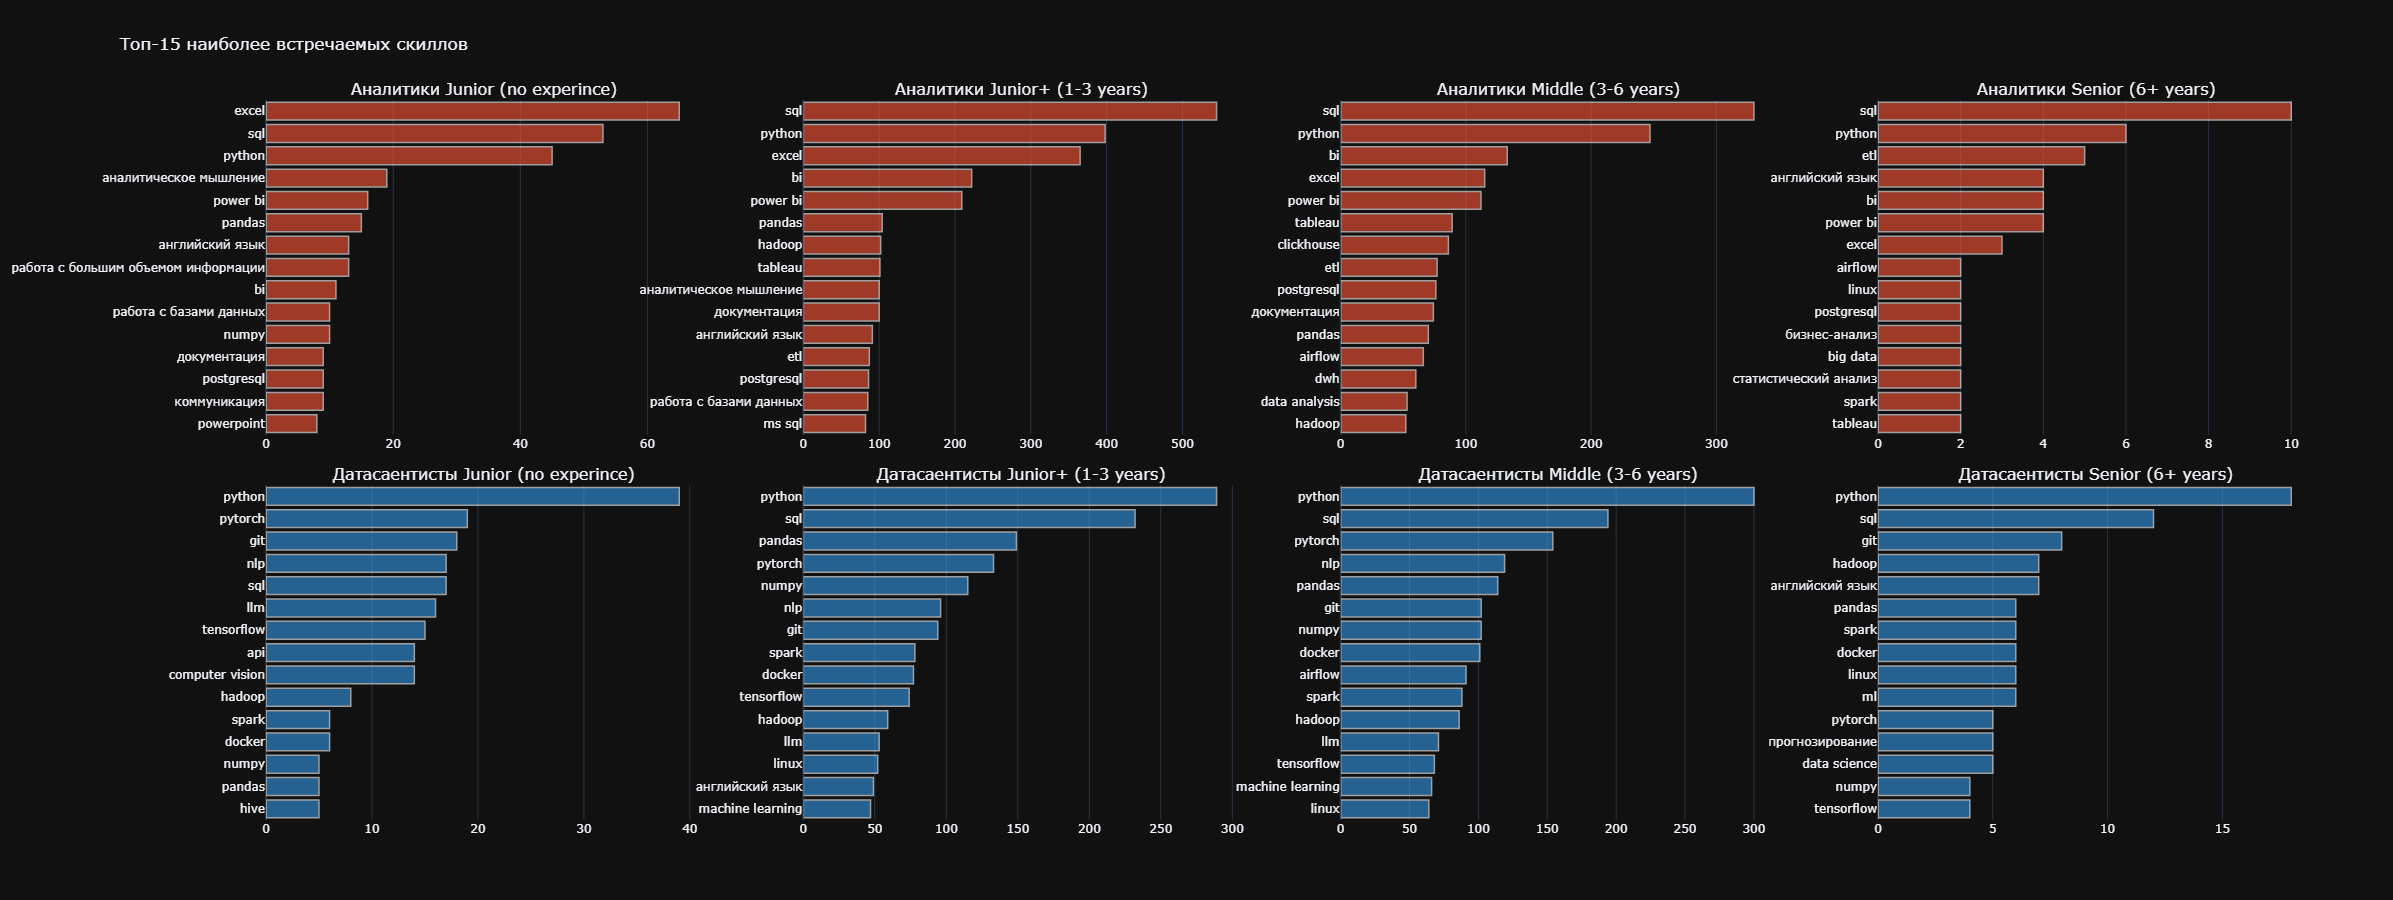

In [163]:
fig = make_subplots(
    rows=2, cols=4, 
    subplot_titles=("Аналитики Junior (no experince)", 
                    "Аналитики Junior+ (1-3 years)", 
                    "Аналитики Middle (3-6 years)", 
                    "Аналитики Senior (6+ years)", 
                    "Датасаентисты Junior (no experince)", 
                    "Датасаентисты Junior+ (1-3 years)", 
                    "Датасаентисты Middle (3-6 years)", 
                    "Датасаентисты Senior (6+ years)"),
    vertical_spacing=0.07
)
grades = ("Junior (no experince)", 
          "Junior+ (1-3 years)", 
          "Middle (3-6 years)", 
          "Senior (6+ years)")

for i, name_experience in enumerate(grades):    
    freq_skills_da = get_frequency_skill('da', name_experience)
    freq_skills_ds = get_frequency_skill('ds', name_experience)
    
    graph = px.bar(freq_skills_da, 'Частота встречаемости', 'Скилл', orientation='h', color_discrete_sequence=['#FF563A'])
    fig.add_trace(graph.data[0], row=1, col=i + 1)
    
    graph = px.bar(freq_skills_ds, 'Частота встречаемости', 'Скилл', orientation='h', color_discrete_sequence=['#3498E8'])
    fig.add_trace(graph.data[0], row=2, col=i + 1)

fig.update_traces(marker_line_color='#FFFFFF', 
                  marker_line_width=1.5, opacity=0.6)

fig.update_layout(
    height=900, width=1600, 
    title_text='Топ-15 наиболее встречаемых скиллов', 
    showlegend=False,
    template="plotly_dark",       
)
fig.show()

Изучение рынка вакансий показывает, что независимо от уровня и специализации, работодатели ценят знание SQL, Python и основ статистики у кандидатов. Для аналитиков на всех уровнях, кроме Senior, важен навык работы с Excel, тогда как для более опытных аналитиков этот инструмент уже не является приоритетным. Отличительной чертой для вакансий аналитиков является также умение работать с BI системами, такими как Power BI и Tableau. При переходе на уровень Middle аналитика, приобретает значение владение ETL процессами и инструментами, включая Airflow. Для Senior аналитиков ключевыми становятся знания Kafka, Spark и Greenplum.

Вакансии датасаентистов выделяются требованиями к специализированным навыкам в области машинного обучения, включая ML, PyTorch и NLP, а также востребованностью таких инструментов, как Docker и Spark. Кроме того, для специалистов Data Science на всех уровнях необходимо знание системы контроля версий Git.

---

## Определение типичного места работы для Аналитика данных и специалист по Data Science

---

In [69]:
def plot_top(feature: str, title: str):
    fig = make_subplots(
        rows=2, cols=4, 
        subplot_titles=("Аналитики Junior (no experince)", 
                        "Аналитики Junior+ (1-3 years)", 
                        "Аналитики Middle (3-6 years)", 
                        "Аналитики Senior (6+ years)", 
                        "Датасаентисты Junior (no experince)", 
                        "Датасаентисты Junior+ (1-3 years)", 
                        "Датасаентисты Middle (3-6 years)", 
                        "Датасаентисты Senior (6+ years)"),
        vertical_spacing=0.07
    )
    grades = ("Junior (no experince)", 
              "Junior+ (1-3 years)", 
              "Middle (3-6 years)", 
              "Senior (6+ years)")
    
    for i, name_experience in enumerate(grades):    
        top_da = vacancies[(vacancies.name_type == 'da') & (vacancies.experience == name_experience)][feature].value_counts()[:10].sort_values()
        top_ds = vacancies[(vacancies.name_type == 'ds') & (vacancies.experience == name_experience)][feature].value_counts()[:10].sort_values()
        
        graph = px.bar(top_da, 'count', top_da.index, orientation='h', color_discrete_sequence=['#FF563A'])
        fig.add_trace(graph.data[0], row=1, col=i + 1)
        
        graph = px.bar(top_ds, 'count', top_da.index, orientation='h', color_discrete_sequence=['#3498E8'])
        fig.add_trace(graph.data[0], row=2, col=i + 1)
    
    fig.update_traces(marker_line_color='#FFFFFF', 
                      marker_line_width=1.5, opacity=0.6)
    
    fig.update_layout(
        height=700, width=1800, 
        title_text=title, 
        showlegend=False,
        template="plotly_dark",       
    )
    fig.show()

Рассмотрим топ-10 работодателей по количеству вакансий

In [70]:
plot_top('employer', 'Топ-10 работодателей')

Анализируя рынок труда, можно отметить, что Сбербанк доминирует по количеству вакансий, исключая позиции Senior, где Леруа Мерлен выходит на первое место. Магнит также выделяется как один из лидеров в привлечении джуниор-аналитиков и датасаентистов, как с опытом, так и без. Банк ВТБ занимает прочное второе место по числу предложений для начинающих аналитиков и специалистов по данным с небольшим опытом. Онлайн-ритейлеры, такие как OZON и Wildberries, также активно ищут новые кадры, предлагая множество вакансий в этих сегментах.

In [71]:
def plot_share(feature: str, title: str):
    fig = make_subplots(
            rows=2, cols=4, 
            subplot_titles=("Аналитики Junior (no experince)", 
                            "Аналитики Junior+ (1-3 years)", 
                            "Аналитики Middle (3-6 years)", 
                            "Аналитики Senior (6+ years)", 
                            "Датасаентисты Junior (no experince)", 
                            "Датасаентисты Junior+ (1-3 years)", 
                            "Датасаентисты Middle (3-6 years)", 
                            "Датасаентисты Senior (6+ years)"),
            vertical_spacing=0.03,
            horizontal_spacing=0.16,
             specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}, {'type':'domain'}], 
                    [{'type':'domain'}, {'type':'domain'}, {'type':'domain'}, {'type':'domain'}]]
        )
    
    grades = ("Junior (no experince)", 
                  "Junior+ (1-3 years)", 
                  "Middle (3-6 years)", 
                  "Senior (6+ years)")
    
    for i, name_experience in enumerate(grades):    
        da_share = vacancies.loc[(vacancies['experience'] == name_experience) & (vacancies.name_type == 'da'), feature].value_counts()
        ds_share = vacancies.loc[(vacancies['experience'] == name_experience) & (vacancies.name_type == 'ds'), feature].value_counts()
    
        fig.add_trace(go.Pie(labels=da_share.index, values=da_share),
                      1, i + 1)
        fig.add_trace(go.Pie(labels=ds_share.index, values=ds_share),
                      2, i + 1)
    
    # Use `hole` to create a donut-like pie chart
    fig.update_layout(
            height=1100, width=1600, 
            title_text=title, 
            showlegend=True,
            template="plotly_dark",   
        )
    
    
    fig.update_traces(textposition='outside', hoverinfo='label+value', 
                      textinfo='percent+label', textfont_size=12,
                      marker=dict(line=dict(color='#FFFFFF', width=2))
                     )
    fig.show()

Рассмотрим распределение типов занятости

In [72]:
plot_share('employment', 'Распределение типа занятости')

Из анализа данных рынка труда следует, что для большинства категорий специалистов, за исключением начинающих аналитиков без опыта, тип занятости, указанный в вакансиях, в основном представлен полной занятостью. Однако 13% вакансий для джуниор-аналитиков предлагают стажировку, в то время как для джуниор-датасаентистов доля стажировок составляет более 30%, и почти такой же процент приходится на проектную работу.

Рассмотрим распределение графика работы

In [73]:
plot_share('schedule', 'Распределение графика работы')

Из данных следует, что с увеличением требуемого уровня опыта у кандидатов на позиции аналитиков возрастает и доля вакансий, предлагающих возможность удаленной работы. В то же время, в сфере Data Science наблюдается обратная тенденция: только половина вакансий для начинающих специалистов без опыта предусматривают полный рабочий день. Для более опытных специалистов этот показатель увеличивается до 65% и выше.

Посмотрим медианную заработную плату по каждой категории.

In [ ]:
salary = vacancies.groupby(['name_type', 'experience'], as_index=False).agg({'salary_num': 'median'})
salary['name_type'] = salary.name_type.map({'da': 'Аналитик данных', 'ds': 'Датасаентист'})
salary.rename(columns={'name_type': 'Вакансия', 'experience': 'Опыт работы', 'salary_num': 'Медианная зарплата'}, inplace=True)

display(salary.style.format(
    "{:.0f}",
    subset='Медианная зарплата'  
).background_gradient(
    subset='Медианная зарплата',
    cmap='Reds',  
    axis=0
))

,Вакансия,Опыт работы,Медианная зарплата
0,Аналитик данных,Junior (no experince),60000
1,Аналитик данных,Junior+ (1-3 years),102500
2,Аналитик данных,Middle (3-6 years),180000
3,Аналитик данных,Senior (6+ years),274104
4,Датасаентист,Junior (no experince),30000
5,Датасаентист,Junior+ (1-3 years),200000
6,Датасаентист,Middle (3-6 years),280000
7,Датасаентист,Senior (6+ years),300000


Видно что зарплаты Аналитика(с соответствующим опытом работы) немногим меньше, чем зарплата датасаентиста, за исключением специалистов без опыта работы. Это может быть потому что у датасаентистов без опыта, больше стажировок в вакансиях, а у стажера все таки зарплата меньше.